#Блок для установки RAPIDS.AI в Colab. Пропустите его, если уже установлен

Для запуска требуется включить Colab в режиме GPU. Далее нужно выполнять ячейки по очереди, при этом требуется ручной контроль, так как иногда среда будет перезагружаться.

In [ ]:
!nvidia-smi

Mon Oct  3 12:43:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pynvml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
H

In [ ]:
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
!python rapidsai-csp-utils/colab/install_rapids.py stable
!pip install --upgrade cffi==1.15.1
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.15.1
Uninstalling cffi-1.15.1:
  Successfully uninstalled cffi-1.15.1
Found existing installation: cryptography 37.0.4
Uninstalling cryptography-37.0.4:
  Successfully uninstalled cryptography-37.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.1/427.1 kB 29.4 MB/s eta 0:00:00
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(649): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(649): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solvin

#Блок с подключение Google Drive, пропустите, если файлы находятся в другом месте

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Основной блок

In [ ]:
PATH_TO_PARQUET = "/content/gdrive/MyDrive/Parquet"

In [ ]:
import cudf

## Активность по часам

In [ ]:
current_df = cudf.read_parquet(PATH_TO_PARQUET, columns=['app_id', "hour", "transaction_number"])

In [ ]:
current_df = current_df.groupby(["app_id", "hour"]).count().reset_index().pivot("app_id", "hour").fillna(0)

In [ ]:
import cupy

Функция для скейла по рядам

In [ ]:
def scale_row(row):
    min = row.min()
    max = row.max()
    return (row - min) / (max - min)

In [ ]:
current_df = cudf.DataFrame(cupy.apply_along_axis(scale_row, axis=1, arr=current_df.to_cupy(dtype='float32')), index=current_df.index)

In [ ]:
import numpy as np

In [ ]:
from cuml import KMeans
from cuml.metrics.cluster import silhouette_score

In [ ]:
random_state = 42

In [ ]:
n_with_scores = []
for i in range(2, 10):
    kmeans_cluster = KMeans(n_clusters=i, random_state=random_state).fit(current_df)
    n_with_scores.append([i, silhouette_score(current_df, kmeans_cluster.labels_)])
n_with_scores = np.array(n_with_scores)

In [ ]:
n_with_scores = np.array(n_with_scores)

In [ ]:
import matplotlib.pyplot as plt

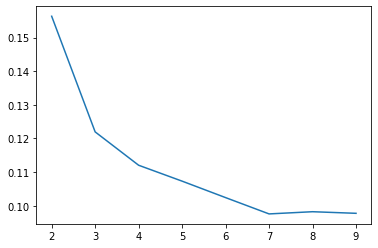

In [ ]:
plt.plot(n_with_scores[:, 0], n_with_scores[:, 1]);
plt.xticks(n_with_scores[:, 0]);

Наилучшее число кластеров – 2. На самом деле значения слишком близкие к нулю и есть подозрение, что это по сути один кластер

In [ ]:
best_n = int(max(n_with_scores, key=lambda tup: tup[1])[0])

In [ ]:
kmeans_cluster = KMeans(n_clusters=best_n, random_state=random_state).fit(current_df)

In [ ]:
import seaborn as sns

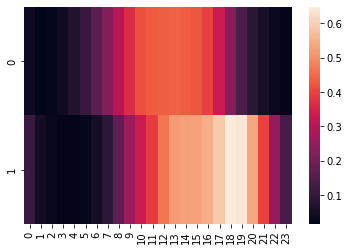

In [ ]:
sns.heatmap(kmeans_cluster.cluster_centers_.to_numpy());

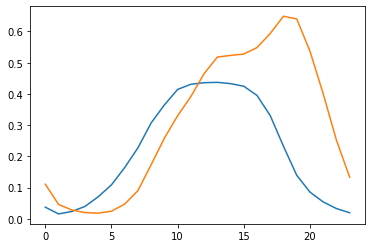

In [ ]:
for i in range(len(kmeans_cluster.cluster_centers_)):
    plt.plot(kmeans_cluster.cluster_centers_.to_numpy()[i])

Пользователи разделились на тех, кто активнее в середине дня и тех, кто активнее вечером

In [ ]:
from cuml import UMAP

In [ ]:
reducer_3d = UMAP(n_components=3, random_state=random_state)

In [ ]:
sample_values = current_df.sample(frac=0.01, random_state=random_state)
sample_labels = kmeans_cluster.labels_.sample(frac=0.01, random_state=random_state).to_numpy()

In [ ]:
reduced_3d = reducer_3d.fit_transform(sample_values).to_numpy()

In [ ]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter_3d(x=reduced_3d[:,0], y=reduced_3d[:,1], z=reduced_3d[:,2], color=sample_labels)
fig.show()

In [ ]:
reducer_2d = UMAP(n_components=2, random_state=random_state)

In [ ]:
reduced_2d = reducer_2d.fit_transform(sample_values).to_numpy()

In [ ]:
fig = px.scatter(x=reduced_2d[:,0], y=reduced_2d[:,1], color=sample_labels)
fig.show()

Все еще есть уверенность, что это на самом деле один кластер, границы очень нечетки и в двухмерном, и в трехмерном случае

## Активность по дням недели

In [ ]:
current_df = cudf.read_parquet(PATH_TO_PARQUET, columns=['app_id', "day_of_week", "transaction_number"])

In [ ]:
current_df = current_df.groupby(["app_id", "day_of_week"]).count().reset_index().pivot("app_id", "day_of_week").fillna(0)

In [ ]:
current_df = cudf.DataFrame(cupy.apply_along_axis(scale_row, axis=1, arr=current_df.to_cupy(dtype='float32')), index=current_df.index)

In [ ]:
n_with_scores = []
for i in range(2, 14):
    kmeans_cluster = KMeans(n_clusters=i, random_state=random_state).fit(current_df)
    n_with_scores.append([i, silhouette_score(current_df, kmeans_cluster.labels_)])
n_with_scores = np.array(n_with_scores)

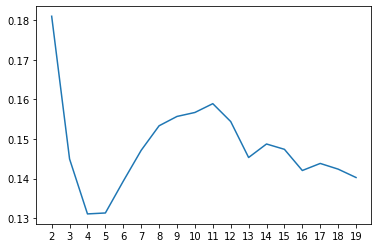

In [ ]:
plt.plot(n_with_scores[:, 0], n_with_scores[:, 1]);
plt.xticks(n_with_scores[:, 0]);

In [ ]:
best_n = int(max(n_with_scores, key=lambda tup: tup[1])[0])

In [ ]:
kmeans_cluster = KMeans(n_clusters=best_n, random_state=random_state).fit(current_df)

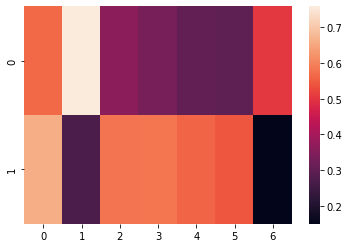

In [ ]:
sns.heatmap(kmeans_cluster.cluster_centers_.to_numpy());

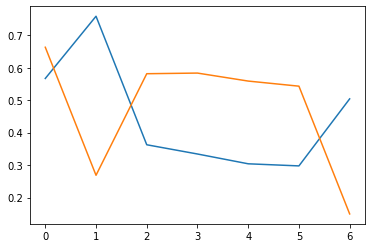

In [ ]:
for i in range(len(kmeans_cluster.cluster_centers_)):
    plt.plot(kmeans_cluster.cluster_centers_.to_numpy()[i])

Интересно, что здесь графики центроидов получились как будто противоположные. Один кластер – кластер пользователей активных в течение недели, другой – активность на выходных и в начале недели

In [ ]:
reducer_3d = UMAP(n_components=3, random_state=random_state)

In [ ]:
sample_values = current_df.sample(frac=0.01, random_state=random_state)
sample_labels = kmeans_cluster.labels_.sample(frac=0.01, random_state=random_state).to_numpy()

In [ ]:
reduced_3d = reducer_3d.fit_transform(sample_values).to_numpy()

In [ ]:
fig = px.scatter_3d(x=reduced_3d[:,0], y=reduced_3d[:,1], z=reduced_3d[:,2], color=sample_labels)
fig.show()

In [ ]:
reducer_2d = UMAP(n_components=2, random_state=random_state)

In [ ]:
reduced_2d = reducer_2d.fit_transform(sample_values).to_numpy()

In [ ]:
fig = px.scatter(x=reduced_2d[:,0], y=reduced_2d[:,1], color=sample_labels)
fig.show()

Визуально кластеры тоже не очень хорошо разделены

## Активность по месяцам

In [ ]:
current_df = cudf.read_parquet(PATH_TO_PARQUET, columns=['app_id', "day_of_week", "weekofyear", "transaction_number"])

In [ ]:
current_df['month'] = (((current_df['weekofyear'] - 1)*7 + current_df['day_of_week']) // 31 + 1)
current_df = current_df[['app_id', "month", "transaction_number"]]

In [ ]:
current_df = current_df.groupby(["app_id", "month"]).count().reset_index().pivot("app_id", "month").fillna(0)

In [ ]:
current_df = cudf.DataFrame(cupy.apply_along_axis(scale_row, axis=1, arr=current_df.to_cupy(dtype='float32')), index=current_df.index)

In [ ]:
n_with_scores = []
for i in range(2, 10):
    kmeans_cluster = KMeans(n_clusters=i, random_state=random_state).fit(current_df)
    n_with_scores.append([i, silhouette_score(current_df, kmeans_cluster.labels_)])
n_with_scores = np.array(n_with_scores)

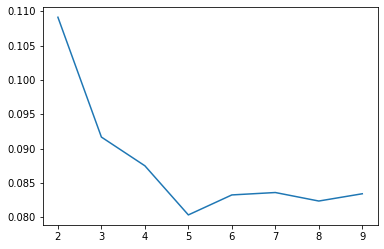

In [ ]:
plt.plot(n_with_scores[:, 0], n_with_scores[:, 1]);
plt.xticks(n_with_scores[:, 0]);

In [ ]:
best_n = int(max(n_with_scores, key=lambda tup: tup[1])[0])

In [ ]:
kmeans_cluster = KMeans(n_clusters=best_n, random_state=random_state).fit(current_df)

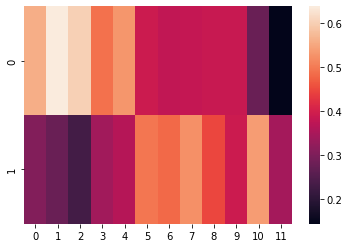

In [ ]:
sns.heatmap(kmeans_cluster.cluster_centers_.to_numpy());

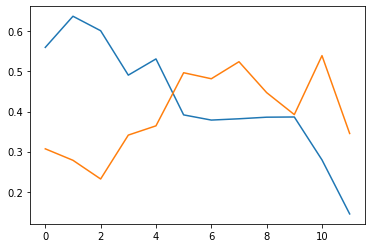

In [ ]:
for i in range(len(kmeans_cluster.cluster_centers_)):
    plt.plot(kmeans_cluster.cluster_centers_.to_numpy()[i])

Тоже интересно, что пользователи разделились на два почти противоположных по активности класса. Класс 0 – активность первые 4 месяца года, класс 1 – остальное время

In [ ]:
reducer_3d = UMAP(n_components=3, random_state=random_state)

In [ ]:
sample_values = current_df.sample(frac=0.01, random_state=random_state)
sample_labels = kmeans_cluster.labels_.sample(frac=0.01, random_state=random_state).to_numpy()

In [ ]:
reduced_3d = reducer_3d.fit_transform(sample_values).to_numpy()

In [ ]:
fig = px.scatter_3d(x=reduced_3d[:,0], y=reduced_3d[:,1], z=reduced_3d[:,2], color=sample_labels)
fig.show()

In [ ]:
reducer_2d = UMAP(n_components=2, random_state=random_state)

In [ ]:
reduced_2d = reducer_2d.fit_transform(sample_values).to_numpy()

In [ ]:
fig = px.scatter(x=reduced_2d[:,0], y=reduced_2d[:,1], color=sample_labels)
fig.show()

Кластеры все еще недостаточно выражены на изображениях.

## Активность по тратам

In [ ]:
current_df = cudf.read_parquet(PATH_TO_PARQUET, columns=['app_id', "amnt", "income_flag", "transaction_number"])

In [ ]:
current_df['income_flag'].value_counts()

1    54968259
2     4530708
3         189
Name: income_flag, dtype: int32

У меня наибольшее количество транзакций расходы. Думаю, что в общем это правило выполняется, так что транзакции с флагом 1 будем считать расходами.

In [ ]:
current_df = current_df[current_df['income_flag'] == 1][['app_id', "amnt", "transaction_number"]]

In [ ]:
amnt_cupy = current_df['amnt'].to_cupy()

In [ ]:
current_df['amnt_percentile'] = cupy.piecewise(amnt_cupy, [amnt_cupy <= 0.1, (amnt_cupy <= 0.2) & (amnt_cupy > 0.1), (amnt_cupy <= 0.3) & (amnt_cupy > 0.2),
            (amnt_cupy <= 0.4) & (amnt_cupy > 0.3), (amnt_cupy <= 0.5) & (amnt_cupy > 0.4),
            (amnt_cupy > 0.5) & (amnt_cupy <= 0.6), (amnt_cupy > 0.6) & (amnt_cupy <= 0.7),
            (amnt_cupy > 0.7) & (amnt_cupy <= 0.8), (amnt_cupy > 0.8) & (amnt_cupy <= 0.9), (amnt_cupy > 0.9)], [0,1,2,3,4,5,6,7,8,9])

In [ ]:
del amnt_cupy

In [ ]:
current_df = current_df[["app_id", "amnt_percentile", "transaction_number"]]

In [ ]:
current_df = current_df.groupby(["app_id", "amnt_percentile"]).count().reset_index().pivot("app_id", "amnt_percentile").fillna(0)

In [ ]:
current_df = cudf.DataFrame(cupy.apply_along_axis(scale_row, axis=1, arr=current_df.to_cupy(dtype='float32')), index=current_df.index)

In [ ]:
n_with_scores = []
for i in range(2, 10):
    kmeans_cluster = KMeans(n_clusters=i, random_state=random_state).fit(current_df)
    n_with_scores.append([i, silhouette_score(current_df, kmeans_cluster.labels_)])
n_with_scores = np.array(n_with_scores)

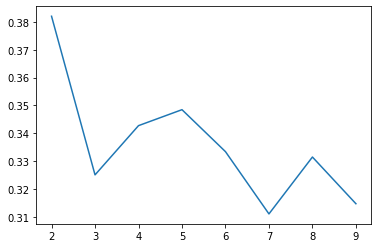

In [ ]:
plt.plot(n_with_scores[:, 0], n_with_scores[:, 1]);
plt.xticks(n_with_scores[:, 0]);

Снова получили 2 кластера

In [ ]:
best_n = int(max(n_with_scores, key=lambda tup: tup[1])[0])

In [ ]:
kmeans_cluster = KMeans(n_clusters=best_n, random_state=random_state).fit(current_df)

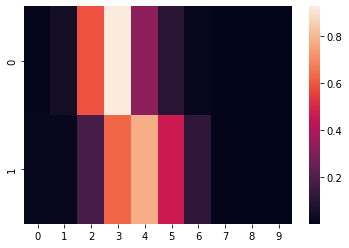

In [ ]:
sns.heatmap(kmeans_cluster.cluster_centers_.to_numpy());

Большинство людей тратят примерно одинаково, кто-то чуть больше, кто-то чуть меньше. В кластере 0 явно люди, который не тратят слишком много, потому что после пика в перцентиле 3 – резкий спад. В кластере 1 явно более гладкое распределение

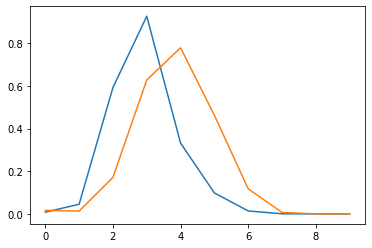

In [ ]:
for i in range(len(kmeans_cluster.cluster_centers_)):
    plt.plot(kmeans_cluster.cluster_centers_.to_numpy()[i])

In [ ]:
reducer_3d = UMAP(n_components=3, random_state=random_state)

In [ ]:
sample_values = current_df.sample(frac=0.01, random_state=random_state)
sample_labels = kmeans_cluster.labels_.sample(frac=0.01, random_state=random_state).to_numpy()

In [ ]:
reduced_3d = reducer_3d.fit_transform(sample_values).to_numpy()

In [ ]:
fig = px.scatter_3d(x=reduced_3d[:,0], y=reduced_3d[:,1], z=reduced_3d[:,2], color=sample_labels)
fig.show()

Вот здесь уже интересно, что кластеры визуально разделены.

In [ ]:
reducer_2d = UMAP(n_components=2, random_state=random_state)

In [ ]:
reduced_2d = reducer_2d.fit_transform(sample_values).to_numpy()

In [ ]:
fig = px.scatter(x=reduced_2d[:,0], y=reduced_2d[:,1], color=sample_labels)
fig.show()

In [ ]:
current_df = cudf.read_parquet(PATH_TO_PARQUET, columns=['app_id', "mcc_category", "transaction_number"])

In [ ]:
current_df = current_df.groupby(["app_id", "mcc_category"]).count().reset_index().pivot("app_id", "mcc_category").fillna(0)

In [ ]:
current_df = cudf.DataFrame(cupy.apply_along_axis(scale_row, axis=1, arr=current_df.to_cupy(dtype='float32')), index=current_df.index)

In [ ]:
n_with_scores = []
for i in range(2, 10):
    kmeans_cluster = KMeans(n_clusters=i, random_state=random_state).fit(current_df)
    n_with_scores.append([i, silhouette_score(current_df, kmeans_cluster.labels_)])
n_with_scores = np.array(n_with_scores)

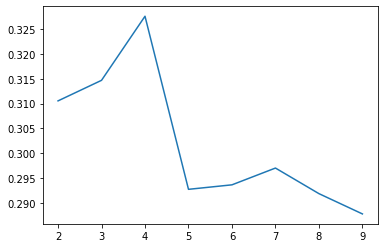

In [ ]:
plt.plot(n_with_scores[:, 0], n_with_scores[:, 1]);
plt.xticks(n_with_scores[:, 0]);

Впервые получили число кластеров отличное от 2

In [ ]:
best_n = int(max(n_with_scores, key=lambda tup: tup[1])[0])

In [ ]:
kmeans_cluster = KMeans(n_clusters=best_n, random_state=random_state).fit(current_df)

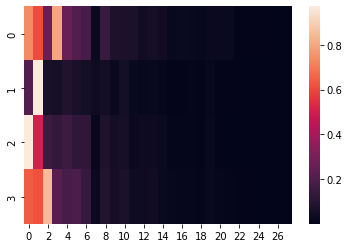

In [ ]:
sns.heatmap(kmeans_cluster.cluster_centers_.to_numpy());

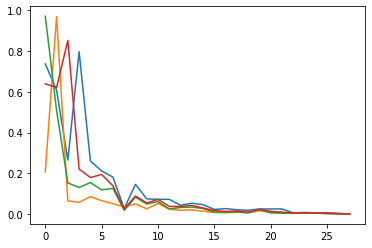

In [ ]:
for i in range(len(kmeans_cluster.cluster_centers_)):
    plt.plot(kmeans_cluster.cluster_centers_.to_numpy()[i])

In [ ]:
reducer_3d = UMAP(n_components=3, random_state=random_state)

In [ ]:
sample_values = current_df.sample(frac=0.01, random_state=random_state)
sample_labels = kmeans_cluster.labels_.sample(frac=0.01, random_state=random_state).to_numpy()

In [ ]:
reduced_3d = reducer_3d.fit_transform(sample_values).to_numpy()

In [ ]:
fig = px.scatter_3d(x=reduced_3d[:,0], y=reduced_3d[:,1], z=reduced_3d[:,2], color=sample_labels)
fig.show()

Не очень понятно, как интерпретировать эти mcc коды, они вроде четырехзначные должны быть. Но стоит сказать, что визуально кластеры все еще не слишом сильно разделены.

In [ ]:
reducer_2d = UMAP(n_components=2, random_state=random_state)

In [ ]:
reduced_2d = reducer_2d.fit_transform(sample_values).to_numpy()

In [ ]:
fig = px.scatter(x=reduced_2d[:,0], y=reduced_2d[:,1], color=sample_labels)
fig.show()

#Дополнительное задание

Буду исследовать, как сильно может быть разбросан silhouette score, если мы считаем его не на всех данных, а на подвыборке.

In [ ]:
real_score = max(n_with_scores, key=lambda tup: tup[1])[1]

In [ ]:
seed_with_silhouette = []
for i in range(1000):
    sample_values = current_df.sample(frac=0.01, random_state=i)
    sample_labels = kmeans_cluster.labels_.sample(frac=0.01, random_state=i)
    seed_with_silhouette.append([i, silhouette_score(sample_values, sample_labels)])
seed_with_silhouette = np.array(seed_with_silhouette)

In [ ]:
fig = px.box(seed_with_silhouette[:, 1], points="all")
fig.add_hline(real_score)

Черная линия – реальная оценка. Как видно, разброс при маленькой подвыборке может быть достаточно большой – 0.02. Хотя в целом кажется, что для самого silhouette score это не слишком значимо, потому что для разного числа кластеров оцена обычно отличается сильнее, чем на сотые. Да и выборка здесь маленькая к тому же. Попробуем взять выборку побольше.

In [ ]:
seed_with_silhouette = []
for i in range(1000):
    sample_values = current_df.sample(frac=0.1, random_state=i)
    sample_labels = kmeans_cluster.labels_.sample(frac=0.1, random_state=i)
    seed_with_silhouette.append([i, silhouette_score(sample_values, sample_labels)])
seed_with_silhouette = np.array(seed_with_silhouette)

In [ ]:
fig = px.box(seed_with_silhouette[:, 1], points="all")
fig.add_hline(real_score)

И здесь разброс уже в тысячных, что точно не очень существенно для данной метрики. Вывод такой – если брать достаточно большые подвыборки, то все будет нормально.